RE50800 – Deep Learning-HW2

Author: RE6121045 數據所碩一 侯登耀

# Loading Packages

In [1]:
import torch
from sklearn.neighbors import KNeighborsClassifier
from skimage.feature import hog
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import ShuffleSplit
import os
import matplotlib.pyplot as plt
import numpy as np
from sklearn.neural_network import MLPClassifier
import cv2
from fast_pytorch_kmeans import KMeans
import pickle
from sklearn.metrics import f1_score, accuracy_score
from joblib import dump, load
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.utils import shuffle
from collections import Counter
from sklearn.linear_model import SGDClassifier
os.chdir("D:\\DY\\深度學習\\Assignment 2\\images")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


# Reading Files and Images

In [2]:
def load_img(f):
    f=open(f)
    lines=f.readlines()
    imgs, lab=[], []
    for i in range(len(lines)):
        fn, label = lines[i].split(' ')

        im1=cv2.imread(fn)
        im1=cv2.resize(im1, (124, 124), interpolation=cv2.INTER_AREA)
        #===============================
        #影像處理的技巧可以放這邊，來增強影像的品質
        im1 = cv2.fastNlMeansDenoising(im1,None,3,7,21)
        im1 = cv2.normalize(im1, None, 0, 255, cv2.NORM_MINMAX)
        #===============================
        im1 = np.moveaxis(im1, 2, 0)
        imgs.append(im1)
        lab.append(int(label))

    lab= np.asarray(lab, np.int32)
    return imgs, lab 

In [3]:
# x, y = load_img('train.txt')
# valx, valy = load_img('val.txt')
# tx, ty = load_img('test.txt')

# np.save('x.npy', x)            
# np.save('y.npy', y)
# np.save('tx.npy', tx)
# np.save('ty.npy', ty)
# np.save('valx.npy', valx)
# np.save('valy.npy', valy) 

In [4]:
x = np.load('./file/x.npy')
y = np.load('./file/y.npy')
valx = np.load('./file/valx.npy')
valy = np.load('./file/valy.npy')
tx = np.load('./file/tx.npy')
ty = np.load('./file/ty.npy')

In [41]:
sum(y==7)

1282

In [36]:
print(len(y))
print(len(valy))
print(len(ty))

63325
450
450


In [5]:
# Load the ImageNet-mini dataset
from torch.utils.data import DataLoader, TensorDataset

x_tensor = torch.from_numpy(np.array(x)).float().to(device)
y_tensor = torch.from_numpy(np.array(y)).long().to(device)
dataset = TensorDataset(x_tensor, y_tensor)

valx_tensor = torch.from_numpy(np.array(valx)).float().to(device)
valy_tensor = torch.from_numpy(np.array(valy)).long().to(device)
val_dataset = TensorDataset(valx_tensor, valy_tensor)

tx_tensor = torch.from_numpy(np.array(tx)).float().to(device)
ty_tensor = torch.from_numpy(np.array(ty)).long().to(device)
t_dataset = TensorDataset(tx_tensor, ty_tensor)

train_loader = DataLoader(dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
t_loader = DataLoader(t_dataset, batch_size=32, shuffle=False)

In [6]:
tx_tensor = torch.from_numpy(np.array(tx)).float().to(device)
ty_tensor = torch.from_numpy(np.array(ty)).long().to(device)
t_dataset = TensorDataset(tx_tensor, ty_tensor)

train_loader = DataLoader(dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
t_loader = DataLoader(t_dataset, batch_size=32, shuffle=False)

In [7]:
# 提取單一通道
R_channel = tx_tensor[:, 0:1, :, :]  # R 通道
G_channel = tx_tensor[:, 1:2, :, :]  # G 通道
B_channel = tx_tensor[:, 2:3, :, :]  # B 通道

In [8]:
zero_channel = torch.zeros_like(R_channel)  # 用來填充的零通道

# 保存單一通道組合，並用零填充其他兩個通道
R_channel_pad = torch.cat((R_channel, zero_channel, zero_channel), dim=1)  # 只有 R
G_channel_pad = torch.cat((zero_channel, G_channel, zero_channel), dim=1)  # 只有 G
B_channel_pad = torch.cat((zero_channel, zero_channel, B_channel), dim=1) # 只有 B

# 提取並組合雙通道，並用零填充缺失的通道
RG_channel_pad  = torch.cat((R_channel, G_channel), dim=1) # RG 通道
RB_channel_pad = torch.cat((R_channel, B_channel), dim=1) # RB 通道
GB_channel_pad = torch.cat((G_channel, B_channel), dim=1)  # GB 通道


In [9]:
t_dataset_R = TensorDataset(R_channel, ty_tensor)
t_dataset_G = TensorDataset(G_channel, ty_tensor)
t_dataset_B = TensorDataset(B_channel, ty_tensor)
t_dataset_RG = TensorDataset(RG_channel_pad, ty_tensor)
t_dataset_RB = TensorDataset(RB_channel_pad, ty_tensor)
t_dataset_GB = TensorDataset(GB_channel_pad, ty_tensor)

t_loader_R = DataLoader(t_dataset_R , batch_size=32, shuffle=False)
t_loader_G = DataLoader(t_dataset_G, batch_size=32, shuffle=False)
t_loader_B = DataLoader(t_dataset_B, batch_size=32, shuffle=False)
t_loader_RB = DataLoader(t_dataset_RB, batch_size=32, shuffle=False)
t_loader_RG = DataLoader(t_dataset_RG, batch_size=32, shuffle=False)
t_loader_GB = DataLoader(t_dataset_GB, batch_size=32, shuffle=False)

# Problem 1.

In [10]:
import torch
from torch import nn
from torch.nn import functional as F

class Attention(nn.Module):
    def __init__(self, in_planes, ratio, K, temprature=30, init_weight=True):
        super().__init__()
        self.avgpool = nn.AdaptiveAvgPool2d(1)
        self.temprature = temprature
        self.in_planes = in_planes  # 添加 in_planes 屬性
        #assert in_planes > ratio
        hidden_planes = in_planes // ratio
        self.net = nn.Sequential(
            nn.Conv2d(in_planes, hidden_planes, kernel_size=1, bias=False),
            nn.ReLU(),
            nn.Conv2d(hidden_planes, K, kernel_size=1, bias=False)
        )

        if init_weight:
            self._initialize_weights()

    def update_temprature(self):
        if self.temprature > 1:
            self.temprature -= 1

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            if isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

    def forward(self, x):
        att = self.avgpool(x)  # bs, in_planes, 1, 1
        att = self.net(att).view(x.shape[0], -1)  # bs, K
        return F.softmax(att / self.temprature, -1)

class VariableInputConv(nn.Module):
    def __init__(self, out_planes, kernel_size, stride, padding=0, dilation=1, groups=1, bias=True, K=4, temprature=30, ratio=1):
        super().__init__()
        self.out_planes = out_planes
        self.kernel_size = kernel_size
        self.stride = stride
        self.padding = padding
        self.dilation = dilation
        self.groups = groups
        self.bias = bias
        self.K = K
        self.temprature = temprature
        self.ratio = ratio

        self.attention = None  # 會在 forward 中根據輸入大小動態初始化

    def forward(self, x):
        bs, in_planes, h, w = x.shape
        device = x.device  # 獲取輸入張量的設備信息
        
        # 動態初始化或更新 Attention 模塊
        if self.attention is None or self.attention.in_planes != in_planes:
            self.attention = Attention(in_planes, self.ratio, self.K, self.temprature).to(device)  # 確保 Attention 在正確的設備上

        # 確保 Attention 模塊的所有參數在正確的設備上
        self.attention.to(device)

        softmax_att = self.attention(x)  # bs, K

        # 動態初始化權重，確保在正確的設備上
        weight = torch.randn(self.K, self.out_planes, in_planes // self.groups, self.kernel_size, self.kernel_size, device=device)
        for i in range(self.K):
            nn.init.kaiming_uniform_(weight[i])

        aggregate_weight = torch.mm(softmax_att, weight.view(self.K, -1)).view(
            bs * self.out_planes, in_planes // self.groups, self.kernel_size, self.kernel_size)

        if self.bias:
            bias = torch.randn(self.K, self.out_planes, device=device)
            for i in range(self.K):
                nn.init.constant_(bias[i], 0)
            aggregate_bias = torch.mm(softmax_att, bias).view(-1)
            output = F.conv2d(x.view(1, -1, h, w), weight=aggregate_weight, bias=aggregate_bias,
                              stride=self.stride, padding=self.padding, groups=self.groups * bs, dilation=self.dilation)
        else:
            output = F.conv2d(x.view(1, -1, h, w), weight=aggregate_weight, bias=None,
                              stride=self.stride, padding=self.padding, groups=self.groups * bs, dilation=self.dilation)

        output = output.view(bs, self.out_planes, h, w)
        return output

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

# 測試 VariableInputConv 模塊

if __name__ == '__main__':
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    input = torch.randn(2, 32, 64, 64).to(device)  # 2 個樣本，每個樣本有 32 個通道，大小為 64x64
    m = VariableInputConv(out_planes=64, kernel_size=3, stride=1, padding=1, bias=False).to(device)
    out = m(input)
    print(out.shape)
    
    input_var_channels = torch.randn(2, 48, 64, 64).to(device)  # 不同的輸入通道數量
    out_var_channels = m(input_var_channels)
    print(out_var_channels.shape)


torch.Size([2, 64, 64, 64])
torch.Size([2, 64, 64, 64])


In [11]:
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out

In [12]:
class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes=1000):
        super(ResNet, self).__init__()
        self.in_channels = 64
        self.conv1 = VariableInputConv(out_planes=64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * block.expansion, num_classes)

    def _make_layer(self, block, out_channels, blocks, stride=1):
        downsample = None
        if stride != 1 or self.in_channels != out_channels * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.in_channels, out_channels * block.expansion, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels * block.expansion),
            )
        layers = []
        layers.append(block(self.in_channels, out_channels, stride, downsample))
        self.in_channels = out_channels * block.expansion
        for _ in range(1, blocks):
            layers.append(block(self.in_channels, out_channels))
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x

In [13]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

dynamic_convolution_model = ResNet(BasicBlock, [2, 2, 2, 2], num_classes=50).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(dynamic_convolution_model.parameters(), lr=0.001, weight_decay=1e-4)

# # Define a StepLR scheduler
# scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min')

Epoch 1: Train Loss: 3.7461 Train Acc: 5.36% Val Loss: 4.4855 Val Acc: 2.22%
Epoch 2: Train Loss: 3.4972 Train Acc: 9.41% Val Loss: 4.4720 Val Acc: 1.56%
Epoch 3: Train Loss: 3.2892 Train Acc: 13.25% Val Loss: 4.6039 Val Acc: 2.22%
Epoch 4: Train Loss: 3.0792 Train Acc: 17.55% Val Loss: 4.4993 Val Acc: 4.89%
Epoch 5: Train Loss: 2.8332 Train Acc: 22.42% Val Loss: 4.1665 Val Acc: 6.44%
Epoch 6: Train Loss: 2.6367 Train Acc: 26.77% Val Loss: 4.4268 Val Acc: 5.33%
Epoch 7: Train Loss: 2.4702 Train Acc: 30.64% Val Loss: 4.4763 Val Acc: 5.33%
Epoch 8: Train Loss: 2.3387 Train Acc: 33.57% Val Loss: 4.4664 Val Acc: 9.11%
Epoch 9: Train Loss: 2.2209 Train Acc: 36.04% Val Loss: 4.2024 Val Acc: 9.33%
Epoch 10: Train Loss: 2.1183 Train Acc: 38.92% Val Loss: 3.7733 Val Acc: 10.44%
Epoch 11: Train Loss: 2.0359 Train Acc: 40.73% Val Loss: 3.9856 Val Acc: 11.11%
Epoch 12: Train Loss: 1.9617 Train Acc: 42.39% Val Loss: 3.7726 Val Acc: 13.11%
Epoch 13: Train Loss: 1.8999 Train Acc: 44.21% Val Loss: 3.4

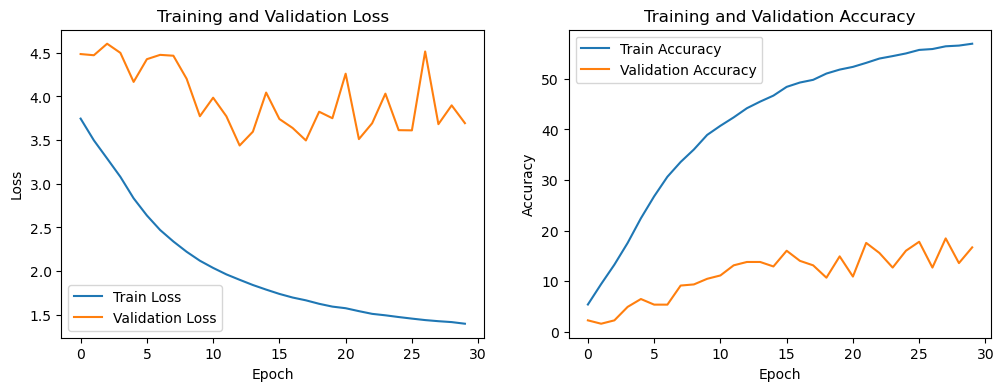

In [14]:
num_epochs = 30
early_stopping_counter = 0
best_val_acc = 0.0
selected_channels = [0, 1, 2] 

# Lists to store loss and accuracy values
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(num_epochs):
    dynamic_convolution_model.train()  # Set model to training mode
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()  # Zero the parameter gradients

        # Forward pass
        outputs = dynamic_convolution_model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()  # Backward pass
        torch.nn.utils.clip_grad_norm_(dynamic_convolution_model.parameters(), max_norm=2.0)  # Gradient clipping
        optimizer.step()  # Optimize the model

        # Statistics
        running_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    epoch_loss = running_loss / total
    epoch_acc = correct / total * 100
    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_acc)

    # Validation
    dynamic_convolution_model.eval()  # Set model to evaluation mode
    val_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = dynamic_convolution_model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_loss /= total
    val_acc = correct / total * 100
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

    print(f'Epoch {epoch + 1}: Train Loss: {epoch_loss:.4f} Train Acc: {epoch_acc:.2f}% Val Loss: {val_loss:.4f} Val Acc: {val_acc:.2f}%')

    if val_acc >= best_val_acc:
        best_val_acc = val_acc
        torch.save(dynamic_convolution_model.state_dict(), 'dynamic_convolution_model.pth')
        early_stopping_counter = 0
    else:
        early_stopping_counter += 1

    if early_stopping_counter > 5:  # Stops if no improvement after 4 epochs
        print("Early stopping triggered.")
        break

# Plotting the training and validation loss
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')

# Plotting the training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')

plt.show()

In [87]:
import torchprofile
input = torch.randn(4, 3, 64, 64).to(device)
# 計算參數數量
num_params = count_parameters(dynamic_convolution_model)
print(f"Number of parameters: {num_params}")

# 使用 torchprofile 計算 FLOPs
macs = torchprofile.profile_macs(dynamic_convolution_model, input)
flops = macs * 2
print(f"FLOPs: {flops}")

input = torch.randn(1, 1, 64, 64).to(device)
num_params = count_parameters(m)
print(f"Number of parameters: {num_params}")

# 使用 torchprofile 計算 FLOPs
macs = torchprofile.profile_macs(m, input)
flops = macs * 2
print(f"FLOPs: {flops}")

Number of parameters: 11192775
FLOPs: 4492505282
Number of parameters: 1152


C:\Users\sljeng\anaconda3\Lib\site-packages\torchprofile\profile.py:22: UserWarning: No handlers found: "aten::randn". Skipped.
  warnings.warn('No handlers found: "{}". Skipped.'.format(
C:\Users\sljeng\anaconda3\Lib\site-packages\torchprofile\profile.py:22: UserWarning: No handlers found: "aten::uniform_". Skipped.
  warnings.warn('No handlers found: "{}". Skipped.'.format(
C:\Users\sljeng\anaconda3\Lib\site-packages\torchprofile\profile.py:22: UserWarning: No handlers found: "aten::mm". Skipped.
  warnings.warn('No handlers found: "{}". Skipped.'.format(


TypeError: Attention.__init__() takes 2 positional arguments but 5 were given

In [43]:
dynamic_convolution_model.eval()
correct = 0
total = 0
with torch.no_grad():
    for inputs, labels in t_loader_R:
        outputs = dynamic_convolution_model(inputs)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

# Print loss and accuracy
print(f"Accuracy of the network on the R test images: {100 * correct / total}%")

with torch.no_grad():
    for inputs, labels in t_loader_G:
        outputs = dynamic_convolution_model(inputs)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

# Print loss and accuracy
print(f"Accuracy of the network on the G test images: {100 * correct / total}%")

with torch.no_grad():
    for inputs, labels in t_loader_B:
        outputs = dynamic_convolution_model(inputs)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

# Print loss and accuracy
print(f"Accuracy of the network on the B test images: {100 * correct / total}%")

with torch.no_grad():
    for inputs, labels in t_loader_RG:
        outputs = dynamic_convolution_model(inputs)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

# Print loss and accuracy
print(f"Accuracy of the network on the RG test images: {100 * correct / total}%")

with torch.no_grad():
    for inputs, labels in t_loader_RB:
        outputs = dynamic_convolution_model(inputs)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

# Print loss and accuracy
print(f"Accuracy of the network on the RB test images: {100 * correct / total}%")

with torch.no_grad():
    for inputs, labels in t_loader_GB:
        outputs = dynamic_convolution_model(inputs)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

# Print loss and accuracy
print(f"Accuracy of the network on the GB test images: {100 * correct / total}%")

with torch.no_grad():
    for inputs, labels in t_loader:
        outputs = dynamic_convolution_model(inputs)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

# Print loss and accuracy
print(f"Accuracy of the network on the RGB test images: {100 * correct / total}%")

Accuracy of the network on the R test images: 18.666666666666668%
Accuracy of the network on the G test images: 16.666666666666668%
Accuracy of the network on the B test images: 15.703703703703704%
Accuracy of the network on the RG test images: 16.055555555555557%
Accuracy of the network on the RB test images: 15.6%
Accuracy of the network on the GB test images: 15.222222222222221%
Accuracy of the network on the RGB test images: 14.603174603174603%


# Problem 2.

# ResNet34 As Base Model

In [44]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.downsample = downsample

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = F.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = F.relu(out)

        return out

class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes=50):
        super(ResNet, self).__init__()
        self.in_channels = 64
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * block.expansion, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

    def _make_layer(self, block, out_channels, blocks, stride=1):
        downsample = None
        if stride != 1 or self.in_channels != out_channels * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.in_channels, out_channels * block.expansion, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels * block.expansion),
            )

        layers = []
        layers.append(block(self.in_channels, out_channels, stride, downsample))
        self.in_channels = out_channels * block.expansion
        for _ in range(1, blocks):
            layers.append(block(self.in_channels, out_channels))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = F.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)

        return x

def resnet34(num_classes=50):
    return ResNet(BasicBlock, [3, 4, 6, 3], num_classes)

# base model
base_model = resnet34(num_classes=50)
print(base_model)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)
base_model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(base_model.parameters(), lr=0.001)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    

In [47]:
# Training loop
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []
num_epochs = 30
for epoch in range(num_epochs):
    base_model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = base_model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        val_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
    epoch_loss = running_loss / total
    epoch_acc = correct / total * 100
    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_acc)
    

    # Validation loop
    base_model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            outputs = base_model(inputs)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {running_loss / len(train_loader)}, Accuracy: {100 * correct / total}%")


Epoch 1/30, Loss: 1.5834435136285678, Accuracy: 42.22222222222222%
Epoch 2/30, Loss: 1.317062273267666, Accuracy: 46.0%
Epoch 3/30, Loss: 1.0367319826497883, Accuracy: 47.55555555555556%
Epoch 4/30, Loss: 0.7704049172788151, Accuracy: 48.22222222222222%
Epoch 5/30, Loss: 0.5355785270459186, Accuracy: 49.111111111111114%
Epoch 6/30, Loss: 0.3748383268021224, Accuracy: 52.22222222222222%
Epoch 7/30, Loss: 0.2857163175291082, Accuracy: 48.44444444444444%
Epoch 8/30, Loss: 0.2258533935338831, Accuracy: 48.0%
Epoch 9/30, Loss: 0.201397883383432, Accuracy: 49.333333333333336%
Epoch 10/30, Loss: 0.17580546241182082, Accuracy: 45.111111111111114%
Epoch 11/30, Loss: 0.15533922311575532, Accuracy: 49.333333333333336%
Epoch 12/30, Loss: 0.14495916267576475, Accuracy: 45.333333333333336%
Epoch 13/30, Loss: 0.1317965313486337, Accuracy: 47.333333333333336%
Epoch 14/30, Loss: 0.12498431376375901, Accuracy: 48.44444444444444%
Epoch 15/30, Loss: 0.11272406381599138, Accuracy: 46.666666666666664%
Epoch

In [52]:
print(train_losses[29])
print(train_accuracies[29])

0.0018332354410085826
97.83339913146467


In [97]:
import torchprofile
input = torch.randn(1, 3, 64, 64).to(device) 
# 計算參數數量
num_params = count_parameters(base_model)
print(f"Number of parameters: {num_params}")

# 使用 torchprofile 計算 FLOPs
macs = torchprofile.profile_macs(base_model, input)
flops = macs * 2
print(f"FLOPs: {flops}")

Number of parameters: 21310322
FLOPs: 598744064


In [127]:
torch.save(base_model.state_dict(), "assignment2_Q2_base_model.pth")

In [11]:
base_model.eval()
correct = 0
total = 0
with torch.no_grad():
    for inputs, labels in t_loader:
        outputs = base_model(inputs)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

# Print loss and accuracy
print(f"Accuracy of the network on the 450 test images: {100 * correct / total}%")

NameError: name 'base_model' is not defined

In [63]:
dcn_model.eval()
correct = 0
total = 0
with torch.no_grad():
    for inputs, labels in t_loader:
        outputs = base_model(inputs)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

# Print loss and accuracy
print(f"Accuracy of the network on the 450 test images: {100 * correct / total}%")

Accuracy of the network on the 450 test images: 46.22222222222222%


In [53]:
import torch
import torch
import torchvision.ops
from torch import nn


class DeformableConv2d(nn.Module):
    def __init__(self,
                 in_channels,
                 out_channels,
                 kernel_size=3,
                 stride=1,
                 padding=1,
                 dilation=1,
                 bias=False):
        super(DeformableConv2d, self).__init__()

        assert type(kernel_size) == tuple or type(kernel_size) == int

        kernel_size = kernel_size if type(kernel_size) == tuple else (kernel_size, kernel_size)
        self.stride = stride if type(stride) == tuple else (stride, stride)
        self.padding = padding
        self.dilation = dilation

        self.offset_conv = nn.Conv2d(in_channels,
                                     2 * kernel_size[0] * kernel_size[1],
                                     kernel_size=kernel_size,
                                     stride=stride,
                                     padding=self.padding,
                                     dilation=self.dilation,
                                     bias=True)

        nn.init.constant_(self.offset_conv.weight, 0.)
        nn.init.constant_(self.offset_conv.bias, 0.)

        self.modulator_conv = nn.Conv2d(in_channels,
                                        1 * kernel_size[0] * kernel_size[1],
                                        kernel_size=kernel_size,
                                        stride=stride,
                                        padding=self.padding,
                                        dilation=self.dilation,
                                        bias=True)

        nn.init.constant_(self.modulator_conv.weight, 0.)
        nn.init.constant_(self.modulator_conv.bias, 0.)

        self.regular_conv = nn.Conv2d(in_channels=in_channels,
                                      out_channels=out_channels,
                                      kernel_size=kernel_size,
                                      stride=stride,
                                      padding=self.padding,
                                      dilation=self.dilation,
                                      bias=bias)

    def forward(self, x):
        # h, w = x.shape[2:]
        # max_offset = max(h, w)/4.

        offset = self.offset_conv(x)  # .clamp(-max_offset, max_offset)
        modulator = 2. * torch.sigmoid(self.modulator_conv(x))
        # op = (n - (k * d - 1) + 2p / s)
        x = torchvision.ops.deform_conv2d(input=x,
                                          offset=offset,
                                          weight=self.regular_conv.weight,
                                          bias=self.regular_conv.bias,
                                          padding=self.padding,
                                          mask=modulator,
                                          stride=self.stride,
                                          dilation=self.dilation)
        return x

In [54]:
import torch
import torch.nn as nn
import torchvision.ops
import torch.optim as optim
import torch.nn.functional as F

class DeformableConv2d(nn.Module):
    def __init__(self,
                 in_channels,
                 out_channels,
                 kernel_size=3,
                 stride=1,
                 padding=1,
                 dilation=1,
                 bias=False):
        super(DeformableConv2d, self).__init__()

        assert type(kernel_size) == tuple or type(kernel_size) == int

        kernel_size = kernel_size if type(kernel_size) == tuple else (kernel_size, kernel_size)
        self.stride = stride if type(stride) == tuple else (stride, stride)
        self.padding = padding
        self.dilation = dilation

        self.offset_conv = nn.Conv2d(in_channels,
                                     2 * kernel_size[0] * kernel_size[1],
                                     kernel_size=kernel_size,
                                     stride=stride,
                                     padding=self.padding,
                                     dilation=self.dilation,
                                     bias=True)

        nn.init.constant_(self.offset_conv.weight, 0.)
        nn.init.constant_(self.offset_conv.bias, 0.)

        self.modulator_conv = nn.Conv2d(in_channels,
                                        1 * kernel_size[0] * kernel_size[1],
                                        kernel_size=kernel_size,
                                        stride=stride,
                                        padding=self.padding,
                                        dilation=self.dilation,
                                        bias=True)

        nn.init.constant_(self.modulator_conv.weight, 0.)
        nn.init.constant_(self.modulator_conv.bias, 0.)

        self.regular_conv = nn.Conv2d(in_channels=in_channels,
                                      out_channels=out_channels,
                                      kernel_size=kernel_size,
                                      stride=stride,
                                      padding=self.padding,
                                      dilation=self.dilation,
                                      bias=bias)

    def forward(self, x):
        offset = self.offset_conv(x)
        modulator = 2. * torch.sigmoid(self.modulator_conv(x))
        x = torchvision.ops.deform_conv2d(input=x,
                                          offset=offset,
                                          weight=self.regular_conv.weight,
                                          bias=self.regular_conv.bias,
                                          padding=self.padding,
                                          mask=modulator,
                                          stride=self.stride,
                                          dilation=self.dilation)
        return x

class Attention(nn.Module):
    def __init__(self, in_channels):
        super(Attention, self).__init__()
        self.attention = nn.Sequential(
            nn.Conv2d(in_channels, in_channels // 8, kernel_size=1),
            nn.ReLU(),
            nn.Conv2d(in_channels // 8, in_channels, kernel_size=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        attention = self.attention(x)
        return x * attention
    
    
class CBAM(nn.Module):
    def __init__(self, channels, r):
        super(CBAM, self).__init__()
        self.channels = channels
        self.r = r
        self.sam = SAM(bias=False)
        self.cam = CAM(channels=self.channels, r=self.r)

    def forward(self, x):
        output = self.cam(x)
        output = self.sam(output)
        return output + x
    
    
class CAM(nn.Module):
    def __init__(self, channels, r):
        super(CAM, self).__init__()
        self.channels = channels
        self.r = r
        self.linear = nn.Sequential(
            nn.Linear(in_features=self.channels, out_features=self.channels//self.r, bias=True),
            nn.ReLU(inplace=True),
            nn.Linear(in_features=self.channels//self.r, out_features=self.channels, bias=True))

    def forward(self, x):
        max = F.adaptive_max_pool2d(x, output_size=1)
        avg = F.adaptive_avg_pool2d(x, output_size=1)
        b, c, _, _ = x.size()
        linear_max = self.linear(max.view(b,c)).view(b, c, 1, 1)
        linear_avg = self.linear(avg.view(b,c)).view(b, c, 1, 1)
        output = linear_max + linear_avg
        output = F.sigmoid(output) * x
        return output
    
class SAM(nn.Module):
    def __init__(self, bias=False):
        super(SAM, self).__init__()
        self.bias = bias
        self.conv = nn.Conv2d(in_channels=2, out_channels=1, kernel_size=7, stride=1, padding=3, dilation=1, bias=self.bias)

    def forward(self, x):
        max = torch.max(x,1)[0].unsqueeze(1)
        avg = torch.mean(x,1).unsqueeze(1)
        concat = torch.cat((max,avg), dim=1)
        output = self.conv(concat)
        output = F.sigmoid(output) * x 
        return output 

In [55]:
class Classifier(nn.Module):
    def __init__(self, num_classes=50):
        super(Classifier, self).__init__()
        self.layer1 = nn.Conv2d(3, 64, kernel_size=5, stride=2, padding=2, bias=True)
        self.attention1 = Attention(64)
        self.bn1 = nn.LayerNorm([64, 64, 64])
        self.pool1 = nn.MaxPool2d(2)
        
        self.layer2 = nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1, bias=True)
        self.bn = nn.LayerNorm([64, 32, 32])
        
        self.layer3 = nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1, bias=True)
        self.layer4 = DeformableConv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1, bias=True)
        self.attention2 = CBAM(128, r=2)
        self.pool2 = nn.MaxPool2d(2)
        self.bn2 = nn.LayerNorm([128, 32, 32])

        self.dropout = nn.Dropout(0.5)
        self.pooling = nn.AdaptiveAvgPool2d((1, 1))
        self.fc1 = nn.Linear(128, 50)

    def forward(self, x):
        x = self.layer1(x)
        x = self.bn1(x)
        x = F.gelu(x) 
        x = self.attention1(x)
        x = self.pool1(x)
        x = self.layer2(x)
        x = self.bn(x)
        x = F.gelu(x) 
        
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.bn2(x)
        x = F.gelu(x) 
        x = self.attention2(x)
        x = self.pool2(x)
        
        x = self.pooling(x)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        return x

# Create a random tensor with the shape (batch_size, channels, height, width)

# Initialize the model
dcn_model = Classifier(num_classes=50).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(dcn_model.parameters(), lr=0.001)
print(dcn_model)

Classifier(
  (layer1): Conv2d(3, 64, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
  (attention1): Attention(
    (attention): Sequential(
      (0): Conv2d(64, 8, kernel_size=(1, 1), stride=(1, 1))
      (1): ReLU()
      (2): Conv2d(8, 64, kernel_size=(1, 1), stride=(1, 1))
      (3): Sigmoid()
    )
  )
  (bn1): LayerNorm((64, 64, 64), eps=1e-05, elementwise_affine=True)
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (layer2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn): LayerNorm((64, 32, 32), eps=1e-05, elementwise_affine=True)
  (layer3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (layer4): DeformableConv2d(
    (offset_conv): Conv2d(64, 18, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (modulator_conv): Conv2d(64, 9, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (regular_conv): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (attention2)

In [56]:
torch.cuda.empty_cache()

In [57]:
import torch
import os

# Training loop
num_epochs = 30
save_dir = './model_checkpoints'  # Directory where model checkpoints will be saved

if not os.path.exists(save_dir):
    os.makedirs(save_dir)
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(num_epochs):
    dcn_model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = dcn_model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        val_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
    epoch_loss = running_loss / total
    epoch_acc = correct / total * 100
    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_acc)

    # Validation loop
    dcn_model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            outputs = dcn_model(inputs)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    # Print loss and accuracy
    print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {running_loss / len(train_loader)}, Accuracy: {100 * correct / total}%")

    # Save model parameters
    checkpoint_path = os.path.join(save_dir, f'model_epoch_{epoch + 1}.pth')
    torch.save({
        'epoch': epoch + 1,                     
        'model_state_dict': dcn_model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': running_loss / len(train_loader),
        'accuracy': 100 * correct / total
    }, checkpoint_path)

    print(f"Model saved at {checkpoint_path}")


Epoch 1/30, Loss: 3.3638417419609006, Accuracy: 18.22222222222222%
Model saved at ./model_checkpoints\model_epoch_1.pth
Epoch 2/30, Loss: 2.870916064548155, Accuracy: 20.666666666666668%
Model saved at ./model_checkpoints\model_epoch_2.pth
Epoch 3/30, Loss: 2.661215045826793, Accuracy: 28.22222222222222%
Model saved at ./model_checkpoints\model_epoch_3.pth
Epoch 4/30, Loss: 2.522314536565479, Accuracy: 27.77777777777778%
Model saved at ./model_checkpoints\model_epoch_4.pth
Epoch 5/30, Loss: 2.411317072533911, Accuracy: 32.666666666666664%
Model saved at ./model_checkpoints\model_epoch_5.pth
Epoch 6/30, Loss: 2.3212589815808644, Accuracy: 34.666666666666664%
Model saved at ./model_checkpoints\model_epoch_6.pth
Epoch 7/30, Loss: 2.2436112280503977, Accuracy: 33.55555555555556%
Model saved at ./model_checkpoints\model_epoch_7.pth
Epoch 8/30, Loss: 2.187019668124191, Accuracy: 33.77777777777778%
Model saved at ./model_checkpoints\model_epoch_8.pth
Epoch 9/30, Loss: 2.1301817713270528, Accu

In [64]:
print(train_losses[29])
print(train_accuracies[29])

0.051436161514896675
50.55665219107778


In [110]:
torch.save(dcn_model.state_dict(), "assignment2_Q2_model.pth")

In [102]:
import torchprofile
input = torch.randn(1, 3, 128, 128).to(device) 
# 計算參數數量
num_params = count_parameters(dcn_model)
print(f"Number of parameters: {num_params}")

# 使用 torchprofile 計算 FLOPs
macs = torchprofile.profile_macs(dcn_model, input)
flops = macs * 2
print(f"FLOPs: {flops}")

Number of parameters: 1109879
FLOPs: 232821760


In [62]:
dcn_model.eval()
correct = 0
total = 0
with torch.no_grad():
    for inputs, labels in t_loader:
        outputs = dcn_model(inputs)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

# Print loss and accuracy
print(f"Accuracy of the network on the 450 test images: {100 * correct / total}%")

Accuracy of the network on the 450 test images: 46.22222222222222%


In [ ]:
dcn_model = torch.load("assignment2_Q2_model.pth")